In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np

def load_depth_csv(path: Path, depth_scale: float = 0.001) -> np.ndarray:
    d = np.loadtxt(path, delimiter=",").astype(np.float32)
    d[d <= 0] = np.nan
    return d * depth_scale

def depth_to_colormap(depth_m: np.ndarray, near: float | None = None, far: float | None = None):
    valid = depth_m[np.isfinite(depth_m)]
    if near is None or far is None:
        if valid.size == 0:
            near, far = 0.2, 1.0
        else:
            near = float(np.percentile(valid, 5))
            far  = float(np.percentile(valid, 95))
            if near == far:
                near, far = max(near - 0.05, 0.05), near + 0.05
    x = np.clip((depth_m - near) / (far - near), 0, 1)
    vis = (x * 255).astype(np.uint8)
    depth_cmap = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    return depth_cmap, near, far

def show_overlay_inline(
    rgb_path: Path,
    depth_csv_path: Path,
    alpha: float = 0.4,
    near: float | None = None,
    far: float | None = None,
    depth_scale: float = 0.001,
    save_dir: Path | None = None,
):
    color = cv2.imread(str(rgb_path))
    if color is None:
        raise FileNotFoundError(f"Could not read RGB image: {rgb_path}")
    depth_m = load_depth_csv(depth_csv_path, depth_scale=depth_scale)
    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")
    depth_cmap, near_used, far_used = depth_to_colormap(depth_m, near, far)
    overlay = cv2.addWeighted(color, 1 - alpha, depth_cmap, alpha, 0)

    # Display inline
    color_rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth_rgb = cv2.cvtColor(depth_cmap, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(color_rgb); plt.title("RGB"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(depth_rgb); plt.title(f"Depth (near={near_used:.2f}m, far={far_used:.2f}m)"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay_rgb); plt.title("Overlay"); plt.axis("off")
    plt.show()

    saved = {}
    if save_dir is not None:
        save_dir = Path(save_dir)
        (save_dir / "overlay").mkdir(parents=True, exist_ok=True)
        (save_dir / "panel").mkdir(parents=True, exist_ok=True)
        (save_dir / "depth_colormap").mkdir(parents=True, exist_ok=True)  # 追加
        stem = rgb_path.stem
        overlay_path = save_dir / "overlay" / f"{stem}.png"
        panel_path = save_dir / "panel" / f"{stem}_panel.png"
        depth_path = save_dir / "depth_colormap" / f"{stem}_depth.png"    # 追加
        
        cv2.imwrite(str(overlay_path), overlay)
        cv2.imwrite(str(depth_path), depth_cmap)                         # 追加
        panel_img = np.hstack([color, depth_cmap, overlay])
        cv2.imwrite(str(panel_path), panel_img)
        saved["overlay"] = str(overlay_path)
        saved["panel"] = str(panel_path)
        saved["depth_colormap"] = str(depth_path)                        # 追加

    return overlay, depth_cmap, near_used, far_used, saved


In [18]:
print(Path("../datasets/train_data/color/2025-01-20T16-56-09.png").exists())

True


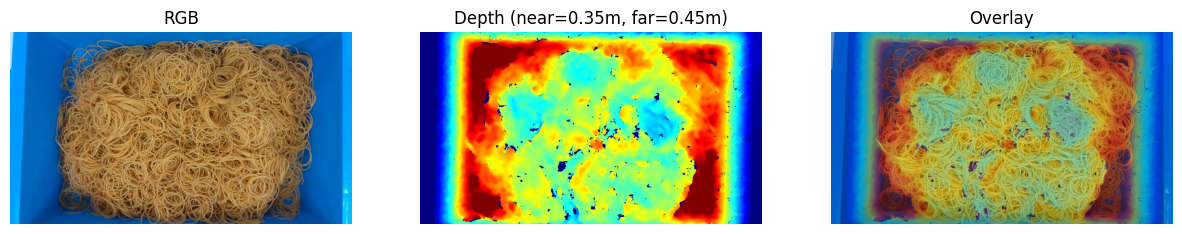

near/far used: 0.35100001096725464 0.4480000138282776
{'overlay': '../datasets/train_data/overlay/2025-01-20T16-56-09.png', 'panel': '../datasets/train_data/panel/2025-01-20T16-56-09_panel.png', 'depth_colormap': '../datasets/train_data/depth_colormap/2025-01-20T16-56-09_depth.png'}


In [20]:
overlay, depth_cmap, near_used, far_used, saved = show_overlay_inline(
    rgb_path=Path("../datasets/train_data/color/2025-01-20T16-56-09.png"),
    depth_csv_path=Path("../datasets/train_data/csv_depth/2025-01-20T16-56-09.csv"),
    alpha=0.4,          # 重ね具合
    near=None, far=None,# 自動推定。固定したければmで指定
    depth_scale=0.001,  # RealSense: uint16 -> m
    #save_dir=None
    save_dir=Path("../datasets/train_data/")  # 保存したくなければ None
)

print("near/far used:", near_used, far_used)
print(saved)

In [ ]:
# make_overlay.py
import cv2, numpy as np
from pathlib import Path
import argparse

def load_depth_csv(path, depth_scale=0.001):
    d = np.loadtxt(path, delimiter=",").astype(np.float32)  # uint16を想定
    d[d <= 0] = np.nan
    return d * depth_scale  # meters

def depth_to_colormap(depth_m, near=None, far=None):
    valid = depth_m[np.isfinite(depth_m)]
    if near is None or far is None:
        if valid.size == 0:
            near, far = 0.2, 1.0
        else:
            near = np.percentile(valid, 5)
            far  = np.percentile(valid, 95)
            if near == far:  # 安全策
                near, far = max(near-0.05, 0.05), near+0.05
    x = np.clip((depth_m - near) / (far - near), 0, 1)
    vis = (x * 255).astype(np.uint8)
    return cv2.applyColorMap(vis, cv2.COLORMAP_JET), near, far

def main(rgb_path, depth_csv, out_path, alpha=0.4, near=None, far=None):
    color = cv2.imread(str(rgb_path))  # BGR
    depth_m = load_depth_csv(depth_csv)  # meters
    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")

    depth_cmap, near, far = depth_to_colormap(depth_m, near, far)
    overlay = cv2.addWeighted(color, 1 - alpha, depth_cmap, alpha, 0)

    # 参考に3連結も保存
    panel = np.hstack([color, depth_cmap, overlay])
    cv2.imwrite(str(out_path), overlay)
    cv2.imwrite(str(Path(out_path).with_name(Path(out_path).stem + "_panel.png")), panel)
    print(f"Saved: {out_path} (near={near:.3f}m, far={far:.3f}m)")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--rgb", required=True)
    ap.add_argument("--depth_csv", required=True)
    ap.add_argument("--out", default="overlay.png")
    ap.add_argument("--alpha", type=float, default=0.4)
    ap.add_argument("--near", type=float, default=None)
    ap.add_argument("--far",  type=float, default=None)
    args = ap.parse_args()
    main(args.rgb, args.depth_csv, args.out, args.alpha, args.near, args.far)